<a href="https://colab.research.google.com/github/1dhiman/100days-ml/blob/master/2019/10_Unsupervised_Learning_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from keras.utils import to_categorical

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import LeakyReLU, Reshape, UpSampling2D, Conv2DTranspose
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adam, RMSprop
from tensorflow.examples.tutorials.mnist import input_data

In [0]:
# Load the datasets
file = 'mnist.pkl.gz'
f = gzip.open(file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [0]:
X_train_keras = X_train.reshape(50000,28,28,1)
X_validation_keras = X_validation.reshape(10000,28,28,1)
X_test_keras = X_test.reshape(10000,28,28,1)

y_train_keras = to_categorical(y_train)
y_validation_keras = to_categorical(y_validation)
y_test_keras = to_categorical(y_test)

In [0]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train),len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation),len(X_train)+ \
                   len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [0]:
def view_digit(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d  Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

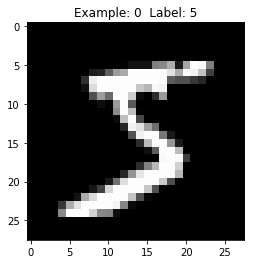

In [7]:
# View the first digit
view_digit(X_train, y_train, 0)

In [8]:
# Confirm use of GPU
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else: print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [9]:
# Convolutional Neural Network (CNN)

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
# Train CNN
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

cnn_history = model.fit(X_train_keras, y_train_keras, 
          validation_data=(X_validation_keras, y_validation_keras), \
          epochs=100)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 28s 561us/step - loss: 0.1859 - acc: 0.9427 - val_loss: 0.0479 - val_acc: 0.9848
Epoch 2/100
50000/50000 [==============================] - 20s 409us/step - loss: 0.0697 - acc: 0.9795 - val_loss: 0.0335 - val_acc: 0.9897
Epoch 3/100
50000/50000 [==============================] - 20s 407us/step - loss: 0.0540 - acc: 0.9841 - val_loss: 0.0280 - val_acc: 0.9925
Epoch 4/100
50000/50000 [==============================] - 21s 411us/step - loss: 0.0438 - acc: 0.9867 - val_loss: 0.0340 - val_acc: 0.9905
Epoch 5/100
50000/50000 [==============================] - 20s 410us/step - loss: 0.0395 - acc: 0.9880 - val_loss: 0.0386 - val_acc: 0.9908
Epoch 6/100
50000/50000 [==============================] - 20s 409us/step - loss: 0.0335 - acc: 0.9895 - val_loss: 0.0286 - val_acc: 0.9922
Epoch 7/100
50

In [11]:
print(cnn_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


CNN Final Accuracy 0.99512


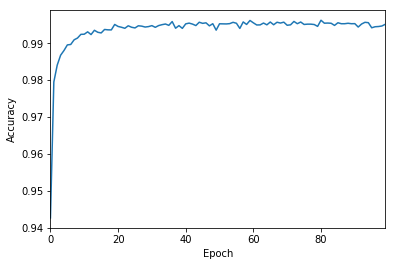

In [12]:
# Plot Accuracy of CNN
print("CNN Final Accuracy", cnn_history.history['acc'][-1])
pd.Series(cnn_history.history['acc']).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [0]:
# DCGAN

class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model
        
    def generator(self, depth=256, dim=7, dropout=0.3, momentum=0.8, \
                  window=5, input_dim=100, output_depth=1):
        if self.G:
            return self.G
        self.G = Sequential()
        self.G.add(Dense(dim*dim*depth, input_dim=input_dim))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))
        
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(output_depth, window, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator(self, depth=64, dropout=0.3, alpha=0.3):
        if self.D:
            return self.D
        self.D = Sequential()
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,
            padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', \
                        optimizer=optimizer, metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', \
                        optimizer=optimizer, metrics=['accuracy'])
        return self.AM
        
class MNIST_DCGAN(object):
    def __init__(self, x_train):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = x_train

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], \
                                                      a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, \
                        samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, \
                    noise=None, step=0):
        current_path = os.getcwd()
        file = '\\images\\chapter12\\synthetic_mnist\\'
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(current_path+file+filename)
            plt.close('all')
        else:
            plt.show()

In [14]:
# Initialize MNIST DCGAN and train
mnist_dcgan = MNIST_DCGAN(X_train_keras)
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=1000, batch_size=256, save_interval=500)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)        

Elapsed: 9.06054084300995 min 


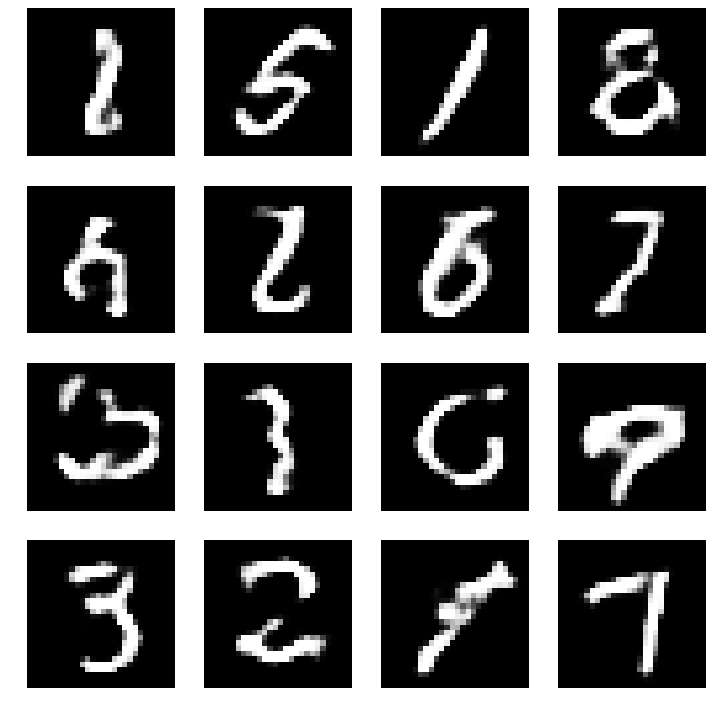

In [15]:
# Generate batch of synthetic MNIST images
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)